In [ ]:
import sys
import os

notebook_path = os.getcwd() 
parent_dir = os.path.dirname(notebook_path)
project_root = os.path.dirname(parent_dir)
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from copy import deepcopy

In [3]:
import state_NN_models
import Filters
import utils
import Systems
from utils import losses, trainer, utils
from torch.utils.data import TensorDataset, DataLoader, random_split
from state_NN_models.StateBayesianKalmanNet import StateBayesianKalmanNet
from state_NN_models.StateKalmanNet import StateKalmanNet
from state_NN_models.StateKalmanNetWithKnownR import StateKalmanNetWithKnownR

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Používané zařízení: {device}")

Používané zařízení: cuda


In [5]:
import torch
from math import pi
import Systems

# =================================================================================
# KROK 1: DEFINICE PARAMETRŮ PRO NELINEÁRNÍ SYSTÉM ("Synthetic")
# =================================================================================
state_dim_nl = 2
obs_dim_nl = 2

# --- Skutečná fyzika ("Ground Truth") ---
# Systém má specifické fázové posuny a tlumení
alpha_true = 0.9
beta_true = 1.1
phi_true = 0.1 * pi
delta_true = 0.01
a_true = 1.0
b_true = 1.0
c_true = 0.0

f_true_nonlinear = lambda x: alpha_true * torch.sin(beta_true * x + phi_true) + delta_true
h_true_nonlinear = lambda x: a_true * (b_true * x + c_true)**2

Q_true_nl = torch.eye(state_dim_nl) * 0.5
R_true_nl = torch.eye(obs_dim_nl) * 0.1
Ex0_true_nl = torch.tensor([[1.0], [0.0]])
P0_true_nl = torch.eye(state_dim_nl) * 1.0

# --- Představa inženýra ("Model Mismatch") ---
# Inženýr si zjednodušil model (vše nastavil na 1.0 nebo 0.0)
alpha_model = 1.0
beta_model = 1.0
phi_model = 0.0
delta_model = 0.0
a_model = 1.0
b_model = 1.0
c_model = 0.0

# f_model_nonlinear = lambda x: alpha_model * torch.sin(beta_model * x + phi_model) + delta_model
# h_model_nonlinear = lambda x: a_model * (b_model * x + c_model)**2

f_model_nonlinear = f_true_nonlinear
h_model_nonlinear = h_true_nonlinear
# Inženýr si navíc myslí, že jeho matematický model je velmi přesný (Q=0.1)
Q_model_nl = Q_true_nl
R_model_nl = R_true_nl
Ex0_model_nl = Ex0_true_nl
P0_model_nl = P0_true_nl

# =================================================================================
# KROK 2: INICIALIZACE OBJEKTŮ SYSTÉMŮ (GMM šum vs. Gaussovský předpoklad)
# =================================================================================
print("\nInicializuji 2D nelineární systém (Fáze 2: Model Mismatch + Outliery)...")

# --- Definice parametrů pro GMM šum (Odlehlé hodnoty / Outliers) ---
gmm_noise_params = {
    'prob_outlier': 0.05,  # 5% šance na obrovskou chybu měření/procesu
    'outlier_scale': 5.0  # Outlier bude mít 5x větší amplitudu než běžný šum
}

# 1. SKUTEČNÁ REALITA (Generuje data)
sys_true = Systems.DynamicSystem(
    state_dim=state_dim_nl, obs_dim=obs_dim_nl,
    Ex0=Ex0_true_nl, P0=P0_true_nl,
    Q=Q_true_nl, R=R_true_nl,
    f=f_true_nonlinear, h=h_true_nonlinear,
    device=device,
    noise_type='gmm',          # Realita obsahuje negaussovské outliery
    gmm_params=gmm_noise_params
)

# 2. CHYBNÝ MODEL (Tento objekt dostanou klasické filtry a AI na vstup)
sys_model = Systems.DynamicSystem(
    state_dim=state_dim_nl, obs_dim=obs_dim_nl,
    Ex0=Ex0_model_nl, P0=P0_model_nl,
    Q=Q_model_nl, R=R_model_nl,
    f=f_model_nonlinear, h=h_model_nonlinear,
    device=device,
    noise_type='gaussian'      # Matematický předpoklad klasických filtrů
)

print("... Systémy pro Fázi 2 inicializovány (sys_true != sys_model).")


Inicializuji 2D nelineární systém (Fáze 2: Model Mismatch + Outliery)...
... Systémy pro Fázi 2 inicializovány (sys_true != sys_model).


In [6]:
TRAIN_SEQ_LEN = 10      # Krátké sekvence pro stabilní trénink (TBPTT)
VALID_SEQ_LEN = 20      # Stejná délka pro konzistentní validaci
TEST_SEQ_LEN = 100      # Dlouhé sekvence pro testování generalizace

NUM_TRAIN_TRAJ = 1000   # Hodně trénovacích příkladů
NUM_VALID_TRAJ = 200    # Dostatek pro spolehlivou validaci
NUM_TEST_TRAJ = 100     # Pro robustní vyhodnocení

BATCH_SIZE = 8         # Dobrý kompromis

x_train, y_train = utils.generate_data(sys_true, num_trajectories=NUM_TRAIN_TRAJ, seq_len=TRAIN_SEQ_LEN)
x_val, y_val = utils.generate_data(sys_true, num_trajectories=NUM_VALID_TRAJ, seq_len=VALID_SEQ_LEN)
x_test, y_test = utils.generate_data(sys_true, num_trajectories=1, seq_len=TEST_SEQ_LEN)

train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import os
import random
import csv
from datetime import datetime
import pandas as pd
from copy import deepcopy

model_config = {
    "hidden_size_multiplier": 12,
    "output_layer_multiplier": 4,
    "num_gru_layers": 1,
    "init_min_dropout": 0.5,
    "init_max_dropout": 0.8
}

train_config = {
    "total_train_iter": 2000,
    "learning_rate": 1e-4,
    "clip_grad": 10.0,
    "J_samples": 10,
    "validation_period": 10,
    "logging_period": 20,
    "warmup_iterations":0, # Trénuj prvních 400 iterací jen na MSE
    "store_model_based_on_hybrid_score": True,
    "calibration_parameter": 0.15
}
# =================================================================================
# KROK 3: SPUŠTĚNÍ JEDNOHO TRÉNINKOVÉHO BĚHU NEBO NAČTENÍ HOTOVÉHO MODELU
# =================================================================================

print("="*80)
print("Připravuji Bayesian KalmanNet (BKN)...")
print(f"Parametry modelu: {model_config}")
print(f"Parametry tréninku: {train_config}")
print("="*80)

# Nastavení seedu pro reprodukovatelnost tohoto běhu
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Definice cesty ke složce a souboru
save_dir = "NonLinearSystemWeights"
os.makedirs(save_dir, exist_ok=True)
weights_path = os.path.join(save_dir, "best_bkn_model_weights_mismatched_better_uncertainity_test.pth")

# Vytvoření modelu (potřebujeme ho inicializovat v obou případech)
state_bkn_knet = StateBayesianKalmanNet(
    sys_model,
    device=device,
    weight_init=False,
    **model_config
).to(device)

# Podmínka pro načtení nebo trénink
if os.path.exists(weights_path):
    print(f"\nINFO: Uložené váhy nalezeny v '{weights_path}'.")
    print("Přeskakuji trénink a načítám hotový model...")
    
    # Načtení vah
    state_bkn_knet.load_state_dict(torch.load(weights_path, map_location=device))
    trained_model = state_bkn_knet
    
else:
    print("\nINFO: Váhy nebyly nalezeny. Spouštím plnohodnotný tréninkový běh...")
    
    # Spuštění tréninku
    results = trainer.training_session_trajectory_with_gaussian_nll_training_fcn(
        model=state_bkn_knet,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        **train_config
    )

    # `run_training_session` automaticky načte nejlepší model zpět,
    # takže `state_bkn_knet` nyní obsahuje váhy nejlepšího modelu.
    trained_model = results['final_model']
    
    # Uložení vah pro příští použití
    torch.save(trained_model.state_dict(), weights_path)
    print(f"\nINFO: Váhy modelu byly úspěšně uloženy do: {weights_path}")

    # Výpis metrik pouze pokud jsme trénovali
    print("\n" + "="*80)
    print("TRÉNINK DOKONČEN - FINÁLNÍ VÝSLEDKY Z NEJLEPŠÍHO MODELU")
    print("="*80)
    print(f"Nejlepší model byl nalezen v iteraci: {results['best_iter']}")
    print(f"Nejlepší dosažený validační ANEES: {results['best_val_anees']:.4f}")
    print("--- Metriky odpovídající tomuto nejlepšímu modelu ---")
    print(f"  MSE na validační sadě:       {results['best_val_mse']:.4f}")
    print(f"  NLL na validační sadě:       {results['best_val_nll']:.4f}")
    print("="*80)

# Prepnutí do evaluačního módu na konci bloku (klíčové pro BKN kvůli Dropoutu)
trained_model.eval()
print("\nModel BKN je plně připraven v proměnné 'trained_model'.")

Připravuji Bayesian KalmanNet (BKN)...
Parametry modelu: {'hidden_size_multiplier': 12, 'output_layer_multiplier': 4, 'num_gru_layers': 1, 'init_min_dropout': 0.5, 'init_max_dropout': 0.8}
Parametry tréninku: {'total_train_iter': 2000, 'learning_rate': 0.0001, 'clip_grad': 10.0, 'J_samples': 10, 'validation_period': 10, 'logging_period': 20, 'warmup_iterations': 0, 'store_model_based_on_hybrid_score': True, 'calibration_parameter': 0.15}
loaded with input normalization

INFO: Váhy nebyly nalezeny. Spouštím plnohodnotný tréninkový běh...

--- Validation at iteration 10 ---
  Average MSE: 3.3619, Average ANEES: 48.5322
  Hybrid Score: 10.3417 (Penalty: 46.5322 * 0.15)
  >>> New best HYBRID SCORE! (10.3417 < inf) Saving model. <<<
--------------------------------------------------
--- Iteration [20/2000] ---
    - Total Loss: 14.2605
    - NLL: 14.2571
    - Reg: 0.0034
    - p1=0.628, p2=0.722

--- Validation at iteration 20 ---
  Average MSE: 3.6821, Average ANEES: 38.3342
  Hybrid Scor

In [8]:

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import os
import random
import csv
from datetime import datetime
import pandas as pd
from copy import deepcopy
# Nastavení seedu pro reprodukovatelnost tohoto běhu
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

save_dir = "NonLinearSystemWeights"
weights_path = os.path.join(save_dir, "best_knet_model_weights_mismatched.pth")

# Vytvoření cílové složky (pokud ještě neexistuje, nic se nestane)
os.makedirs(save_dir, exist_ok=True)


state_knetR = StateKalmanNet(sys_model, device=device, hidden_size_multiplier=12,returns_covariance=True).to(device)

if os.path.exists(weights_path):
    print(f"INFO: Uložené váhy nalezeny v '{weights_path}'.")
    print("Přeskakuji trénink a načítám hotový model...")
    
    # Načtení vah (map_location zajistí kompatibilitu, pokud bys např. trénoval na GPU a načítal na CPU)
    state_knetR.load_state_dict(torch.load(weights_path, map_location=device))
    
else:
    print("INFO: Váhy nebyly nalezeny. Spouštím trénink modelu...")
    
    # Spuštění tréninku
    trainer.train_state_KalmanNet(
        model=state_knetR, 
        train_loader=train_loader, 
        val_loader=val_loader, 
        device=device, 
        epochs=100, 
        lr=1e-4,
        early_stopping_patience=30,
        weight_decay=1e-3
    )
    
    # Po úspěšném tréninku váhy rovnou uložíme pro příští spuštění
    torch.save(state_knetR.state_dict(), weights_path)
    print(f"Trénink dokončen. Váhy byly bezpečně uloženy do '{weights_path}'.")

# Prepnutí do evaluačního módu (dobrá praxe před testováním)
state_knetR.eval()

DEBUG: Layer 'output_final_linear.0' initialized near zero (Start K=0).
INFO: Váhy nebyly nalezeny. Spouštím trénink modelu...
New best model saved! Epoch [1/100], Train Loss: 1.404284, Val Loss: 1.697914
New best model saved! Epoch [2/100], Train Loss: 1.359412, Val Loss: 1.686571
New best model saved! Epoch [3/100], Train Loss: 1.339938, Val Loss: 1.673926
New best model saved! Epoch [4/100], Train Loss: 1.324773, Val Loss: 1.641877
Epoch [5/100] | Train Loss: 1.2973 (Pos: 0.00, Vel: 0.00) | Val Loss: 1.6291 | Val MSE: 1.63
Epoch [4/100], Train Loss: 1.324773, Val Loss: 1.641877, Avg Cov Trace: 0.005511
New best model saved! Epoch [5/100], Train Loss: 1.297309, Val Loss: 1.629065
New best model saved! Epoch [6/100], Train Loss: 1.276397, Val Loss: 1.617746
New best model saved! Epoch [8/100], Train Loss: 1.259917, Val Loss: 1.614933
New best model saved! Epoch [9/100], Train Loss: 1.247775, Val Loss: 1.594521
Epoch [10/100] | Train Loss: 1.2385 (Pos: 0.00, Vel: 0.00) | Val Loss: 1.58

StateKalmanNet(
  (dnn): DNN_KalmanNet(
    (input_layer): Sequential(
      (0): Linear(in_features=8, out_features=384, bias=True)
      (1): ReLU()
    )
    (gru): GRU(384, 8)
    (output_hidden_layer): Sequential(
      (0): Linear(in_features=8, out_features=16, bias=True)
      (1): ReLU()
    )
    (output_final_linear): Sequential(
      (0): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)

In [9]:
import torch
import torch.nn.functional as F
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import Filters

# ==============================================================================
# 0. PŘEDPOKLADY - ZDE PŘIŘAĎTE VAŠE NATRÉNOVANÉ MODELY
# ==============================================================================
try:
    trained_model_bkn = trained_model
    trained_model_knetR = state_knetR
    print("INFO: Všechny natrénované modely nalezeny a přiřazeny.")
except NameError:
    print("VAROVÁNÍ: Některé z proměnných `trained_model`, nebo `state_knetR` nebyly nalezeny.")
    print("         Ujistěte se, že jste nejprve úspěšně dokončili trénink všech modelů.")

trained_model_knetR.returns_covariance=True

# ==============================================================================
# 1. KONFIGURACE TESTU
# ==============================================================================
TEST_SEQ_LEN = 300
NUM_TEST_TRAJ = 10
J_SAMPLES_TEST = 50

# ==============================================================================
# 2. PŘÍPRAVA DAT (Nelineární Gaussovský systém)
# ==============================================================================
print(f"\nGeneruji {NUM_TEST_TRAJ} testovacích trajektorií o délce {TEST_SEQ_LEN}...")
x_test, y_test = utils.generate_data(sys_true, num_trajectories=NUM_TEST_TRAJ, seq_len=TEST_SEQ_LEN)
test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
print("Generování dat dokončeno.")

# ==============================================================================
# 3. INICIALIZACE VŠECH FILTRŮ PRO POROVNÁNÍ (IDEÁLNÍ MODEL)
# ==============================================================================
ekf_ideal = Filters.ExtendedKalmanFilter(sys_model)
ukf_ideal = Filters.UnscentedKalmanFilter(sys_model)
# Particle filtr s vysokým počtem částic představuje "zlatý standard" pro nelinearity
pf_ideal = Filters.VectorizedParticleFilter(sys_model, num_particles=1000000)

print("Všechny model-based filtry (EKF, UKF, PF) s ideálním modelem inicializovány.")

# ==============================================================================
# 4. VYHODNOCOVACÍ SMYČKA
# ==============================================================================
all_x_true_cpu = []
all_x_hat_bkn_cpu, all_P_hat_bkn_cpu = [], []
all_x_hat_knetR_cpu, all_P_hat_knetR_cpu = [], []
all_x_hat_ekf_ideal_cpu, all_P_hat_ekf_ideal_cpu = [], []
all_x_hat_ukf_ideal_cpu, all_P_hat_ukf_ideal_cpu = [], []
all_x_hat_pf_ideal_cpu, all_P_hat_pf_ideal_cpu = [], []

print(f"\nVyhodnocuji modely na {NUM_TEST_TRAJ} testovacích trajektoriích...")

trained_model_bkn.eval() 
trained_model_knetR.eval()

with torch.no_grad():
    for i, (x_true_seq_batch, y_test_seq_batch) in enumerate(test_loader):
        y_test_seq_gpu = y_test_seq_batch.squeeze(0).to(device)
        x_true_seq_gpu = x_true_seq_batch.squeeze(0).to(device)
        initial_state = x_true_seq_gpu[0, :].unsqueeze(0)
        
        # --- A. Bayesian KalmanNet (Trajectory-wise) ---
        ensemble_trajectories = []
        for j in range(J_SAMPLES_TEST):
            trained_model_bkn.reset(batch_size=1, initial_state=initial_state)
            current_x_hats = []
            for t in range(1, TEST_SEQ_LEN):
                x_filtered_t, _ = trained_model_bkn.step(y_test_seq_gpu[t, :].unsqueeze(0))
                current_x_hats.append(x_filtered_t)
            ensemble_trajectories.append(torch.cat(current_x_hats, dim=0))
        ensemble = torch.stack(ensemble_trajectories, dim=0)
        predictions_bkn = ensemble.mean(dim=0)
        diff = ensemble - predictions_bkn.unsqueeze(0)
        covariances_bkn = (diff.unsqueeze(-1) @ diff.unsqueeze(-2)).mean(dim=0)
        full_x_hat_bkn = torch.cat([initial_state, predictions_bkn], dim=0)
        full_P_hat_bkn = torch.cat([sys_true.P0.unsqueeze(0), covariances_bkn], dim=0)

        # --- B. StateKalmanNetWithKnownR ---
        trained_model_knetR.reset(batch_size=1, initial_state=initial_state)
        knetR_preds_x, knetR_preds_P = [], []
        for t in range(1, TEST_SEQ_LEN):
            x_filtered_t, P_filtered_t = trained_model_knetR.step(y_test_seq_gpu[t, :].unsqueeze(0))
            knetR_preds_x.append(x_filtered_t)
            knetR_preds_P.append(P_filtered_t)
        full_x_hat_knetR = torch.cat([initial_state, torch.cat(knetR_preds_x, dim=0)], dim=0)
        
        processed_P_list = []
        for p_tensor in knetR_preds_P:
            while p_tensor.dim() < 2:
                p_tensor = p_tensor.unsqueeze(-1)
            if p_tensor.dim() > 2 and p_tensor.shape[0] == 1:
                p_tensor = p_tensor.squeeze(0)
            processed_P_list.append(p_tensor)

        P_sequence_knetR = torch.stack(processed_P_list, dim=0)
        
        P0_for_cat = sys_true.P0.clone()
        while P0_for_cat.dim() < P_sequence_knetR.dim():
            P0_for_cat = P0_for_cat.unsqueeze(0)
            
        full_P_hat_knetR = torch.cat([P0_for_cat, P_sequence_knetR], dim=0)

        # --- C. EKF (Ideální) ---
        ekf_i_res = ekf_ideal.process_sequence(y_test_seq_gpu, Ex0=sys_true.Ex0, P0=sys_true.P0)
        full_x_hat_ekf_i = ekf_i_res['x_filtered']
        full_P_hat_ekf_i = ekf_i_res['P_filtered']

        # --- D. UKF (Ideální) ---
        ukf_i_res = ukf_ideal.process_sequence(y_test_seq_gpu, Ex0=sys_true.Ex0, P0=sys_true.P0)
        full_x_hat_ukf_i = ukf_i_res['x_filtered']
        full_P_hat_ukf_i = ukf_i_res['P_filtered']

        # --- E. Particle Filter (Ideální) ---
        pf_i_res = pf_ideal.process_sequence(y_test_seq_gpu, Ex0=sys_true.Ex0, P0=sys_true.P0)
        full_x_hat_pf_i = pf_i_res['x_filtered']
        full_P_hat_pf_i = pf_i_res['P_filtered']

        # Ukládání pro výpočet metrik
        all_x_true_cpu.append(x_true_seq_gpu.cpu())
        all_x_hat_bkn_cpu.append(full_x_hat_bkn.cpu()); all_P_hat_bkn_cpu.append(full_P_hat_bkn.cpu())
        all_x_hat_knetR_cpu.append(full_x_hat_knetR.cpu()); all_P_hat_knetR_cpu.append(full_P_hat_knetR.cpu())
        all_x_hat_ekf_ideal_cpu.append(full_x_hat_ekf_i.cpu()); all_P_hat_ekf_ideal_cpu.append(full_P_hat_ekf_i.cpu())
        all_x_hat_ukf_ideal_cpu.append(full_x_hat_ukf_i.cpu()); all_P_hat_ukf_ideal_cpu.append(full_P_hat_ukf_i.cpu())
        all_x_hat_pf_ideal_cpu.append(full_x_hat_pf_i.cpu()); all_P_hat_pf_ideal_cpu.append(full_P_hat_pf_i.cpu())

        print(f"Dokončena trajektorie {i + 1}/{NUM_TEST_TRAJ}...")

# ==============================================================================
# 5. FINÁLNÍ VÝPOČET A VÝPIS METRIK
# ==============================================================================
# Seznamy pro sběr metrik
mse_bkn, anees_bkn = [], []
mse_knetR, anees_knetR = [], []
mse_ekf_ideal, anees_ekf_ideal = [], []
mse_ukf_ideal, anees_ukf_ideal = [], []
mse_pf_ideal, anees_pf_ideal = [], []

print("\nPočítám finální metriky pro jednotlivé trajektorie...")

with torch.no_grad():
    for i in range(NUM_TEST_TRAJ):
        x_true = all_x_true_cpu[i]
        
        def get_metrics(x_hat, P_hat):
            mse = F.mse_loss(x_hat[1:], x_true[1:]).item()
            anees = utils.calculate_anees_vectorized(x_true.unsqueeze(0), x_hat.unsqueeze(0), P_hat.unsqueeze(0))
            return mse, anees

        # Výpočty pro všechny modely
        mse, anees = get_metrics(all_x_hat_bkn_cpu[i], all_P_hat_bkn_cpu[i]); mse_bkn.append(mse); anees_bkn.append(anees)
        mse, anees = get_metrics(all_x_hat_knetR_cpu[i], all_P_hat_knetR_cpu[i]); mse_knetR.append(mse); anees_knetR.append(anees)
        mse, anees = get_metrics(all_x_hat_ekf_ideal_cpu[i], all_P_hat_ekf_ideal_cpu[i]); mse_ekf_ideal.append(mse); anees_ekf_ideal.append(anees)
        mse, anees = get_metrics(all_x_hat_ukf_ideal_cpu[i], all_P_hat_ukf_ideal_cpu[i]); mse_ukf_ideal.append(mse); anees_ukf_ideal.append(anees)
        mse, anees = get_metrics(all_x_hat_pf_ideal_cpu[i], all_P_hat_pf_ideal_cpu[i]); mse_pf_ideal.append(mse); anees_pf_ideal.append(anees)

# Funkce pro bezpečné průměrování
def avg(metric_list): return np.mean([m for m in metric_list if not np.isnan(m)])
state_dim_for_nees = all_x_true_cpu[0].shape[1]

# --- Finální výpis tabulky ---
print("\n" + "="*85)
print(f"FINÁLNÍ VÝSLEDKY: FÁZE 1 - NELINEARITA BEZ MISMATCHU (průměr přes {NUM_TEST_TRAJ} běhů)")
print("="*85)
print(f"{'Model':<35} | {'Průměrné MSE':<20} | {'Průměrný ANEES':<20}")
print("-" * 85)
print(f"{'--- Data-Driven Models ---':<35} | {'(nižší je lepší)':<20} | {'(bližší ' + str(float(state_dim_for_nees)) + ' je lepší)':<20}")
print(f"{'Bayesian KNet (BKN)':<35} | {avg(mse_bkn):<20.4f} | {avg(anees_bkn):<20.4f}")
print(f"{'KNet with Known R (KNetR)':<35} | {avg(mse_knetR):<20.4f} | {avg(anees_knetR):<20.4f}")
print("-" * 85)
print(f"{'--- Model-Based Filters (Ideální) ---':<35} | {'':<20} | {'':<20}")
print(f"{'EKF (Ideální model)':<35} | {avg(mse_ekf_ideal):<20.4f} | {avg(anees_ekf_ideal):<20.4f}")
print(f"{'UKF (Ideální model)':<35} | {avg(mse_ukf_ideal):<20.4f} | {avg(anees_ukf_ideal):<20.4f}")
print(f"{'Particle Filter (Ideální, 100k)':<35} | {avg(mse_pf_ideal):<20.4f} | {avg(anees_pf_ideal):<20.4f}")
print("="*85)

INFO: Všechny natrénované modely nalezeny a přiřazeny.

Generuji 10 testovacích trajektorií o délce 300...
Generování dat dokončeno.
Všechny model-based filtry (EKF, UKF, PF) s ideálním modelem inicializovány.

Vyhodnocuji modely na 10 testovacích trajektoriích...


Processing PF (GPU): 100%|██████████| 299/299 [00:04<00:00, 62.46it/s]


Dokončena trajektorie 1/10...


Processing PF (GPU): 100%|██████████| 299/299 [00:04<00:00, 62.77it/s]


Dokončena trajektorie 2/10...


Processing PF (GPU): 100%|██████████| 299/299 [00:04<00:00, 63.00it/s]


Dokončena trajektorie 3/10...


Processing PF (GPU): 100%|██████████| 299/299 [00:04<00:00, 62.95it/s]


Dokončena trajektorie 4/10...


Processing PF (GPU): 100%|██████████| 299/299 [00:04<00:00, 62.82it/s]


Dokončena trajektorie 5/10...


Processing PF (GPU): 100%|██████████| 299/299 [00:04<00:00, 62.79it/s]


Dokončena trajektorie 6/10...


Processing PF (GPU): 100%|██████████| 299/299 [00:04<00:00, 63.01it/s]


Dokončena trajektorie 7/10...


Processing PF (GPU): 100%|██████████| 299/299 [00:04<00:00, 63.10it/s]


Dokončena trajektorie 8/10...


Processing PF (GPU): 100%|██████████| 299/299 [00:04<00:00, 62.89it/s]


Dokončena trajektorie 9/10...


Processing PF (GPU): 100%|██████████| 299/299 [00:04<00:00, 62.87it/s]

Dokončena trajektorie 10/10...

Počítám finální metriky pro jednotlivé trajektorie...

FINÁLNÍ VÝSLEDKY: FÁZE 1 - NELINEARITA BEZ MISMATCHU (průměr přes 10 běhů)
Model                               | Průměrné MSE         | Průměrný ANEES      
-------------------------------------------------------------------------------------
--- Data-Driven Models ---          | (nižší je lepší)     | (bližší 2.0 je lepší)
Bayesian KNet (BKN)                 | 1.7198               | 2.1871              
KNet with Known R (KNetR)           | 1.5805               | 2596.1033           
-------------------------------------------------------------------------------------
--- Model-Based Filters (Ideální) --- |                      |                     
EKF (Ideální model)                 | 15.2804              | 451.5735            
UKF (Ideální model)                 | 5.6311               | 41.6559             
Particle Filter (Ideální, 100k)     | 1.6957               | 48199298315059.2031 



Generuji grafy vývoje chyby a 3-sigma obálek pro prvních 5 trajektorií...


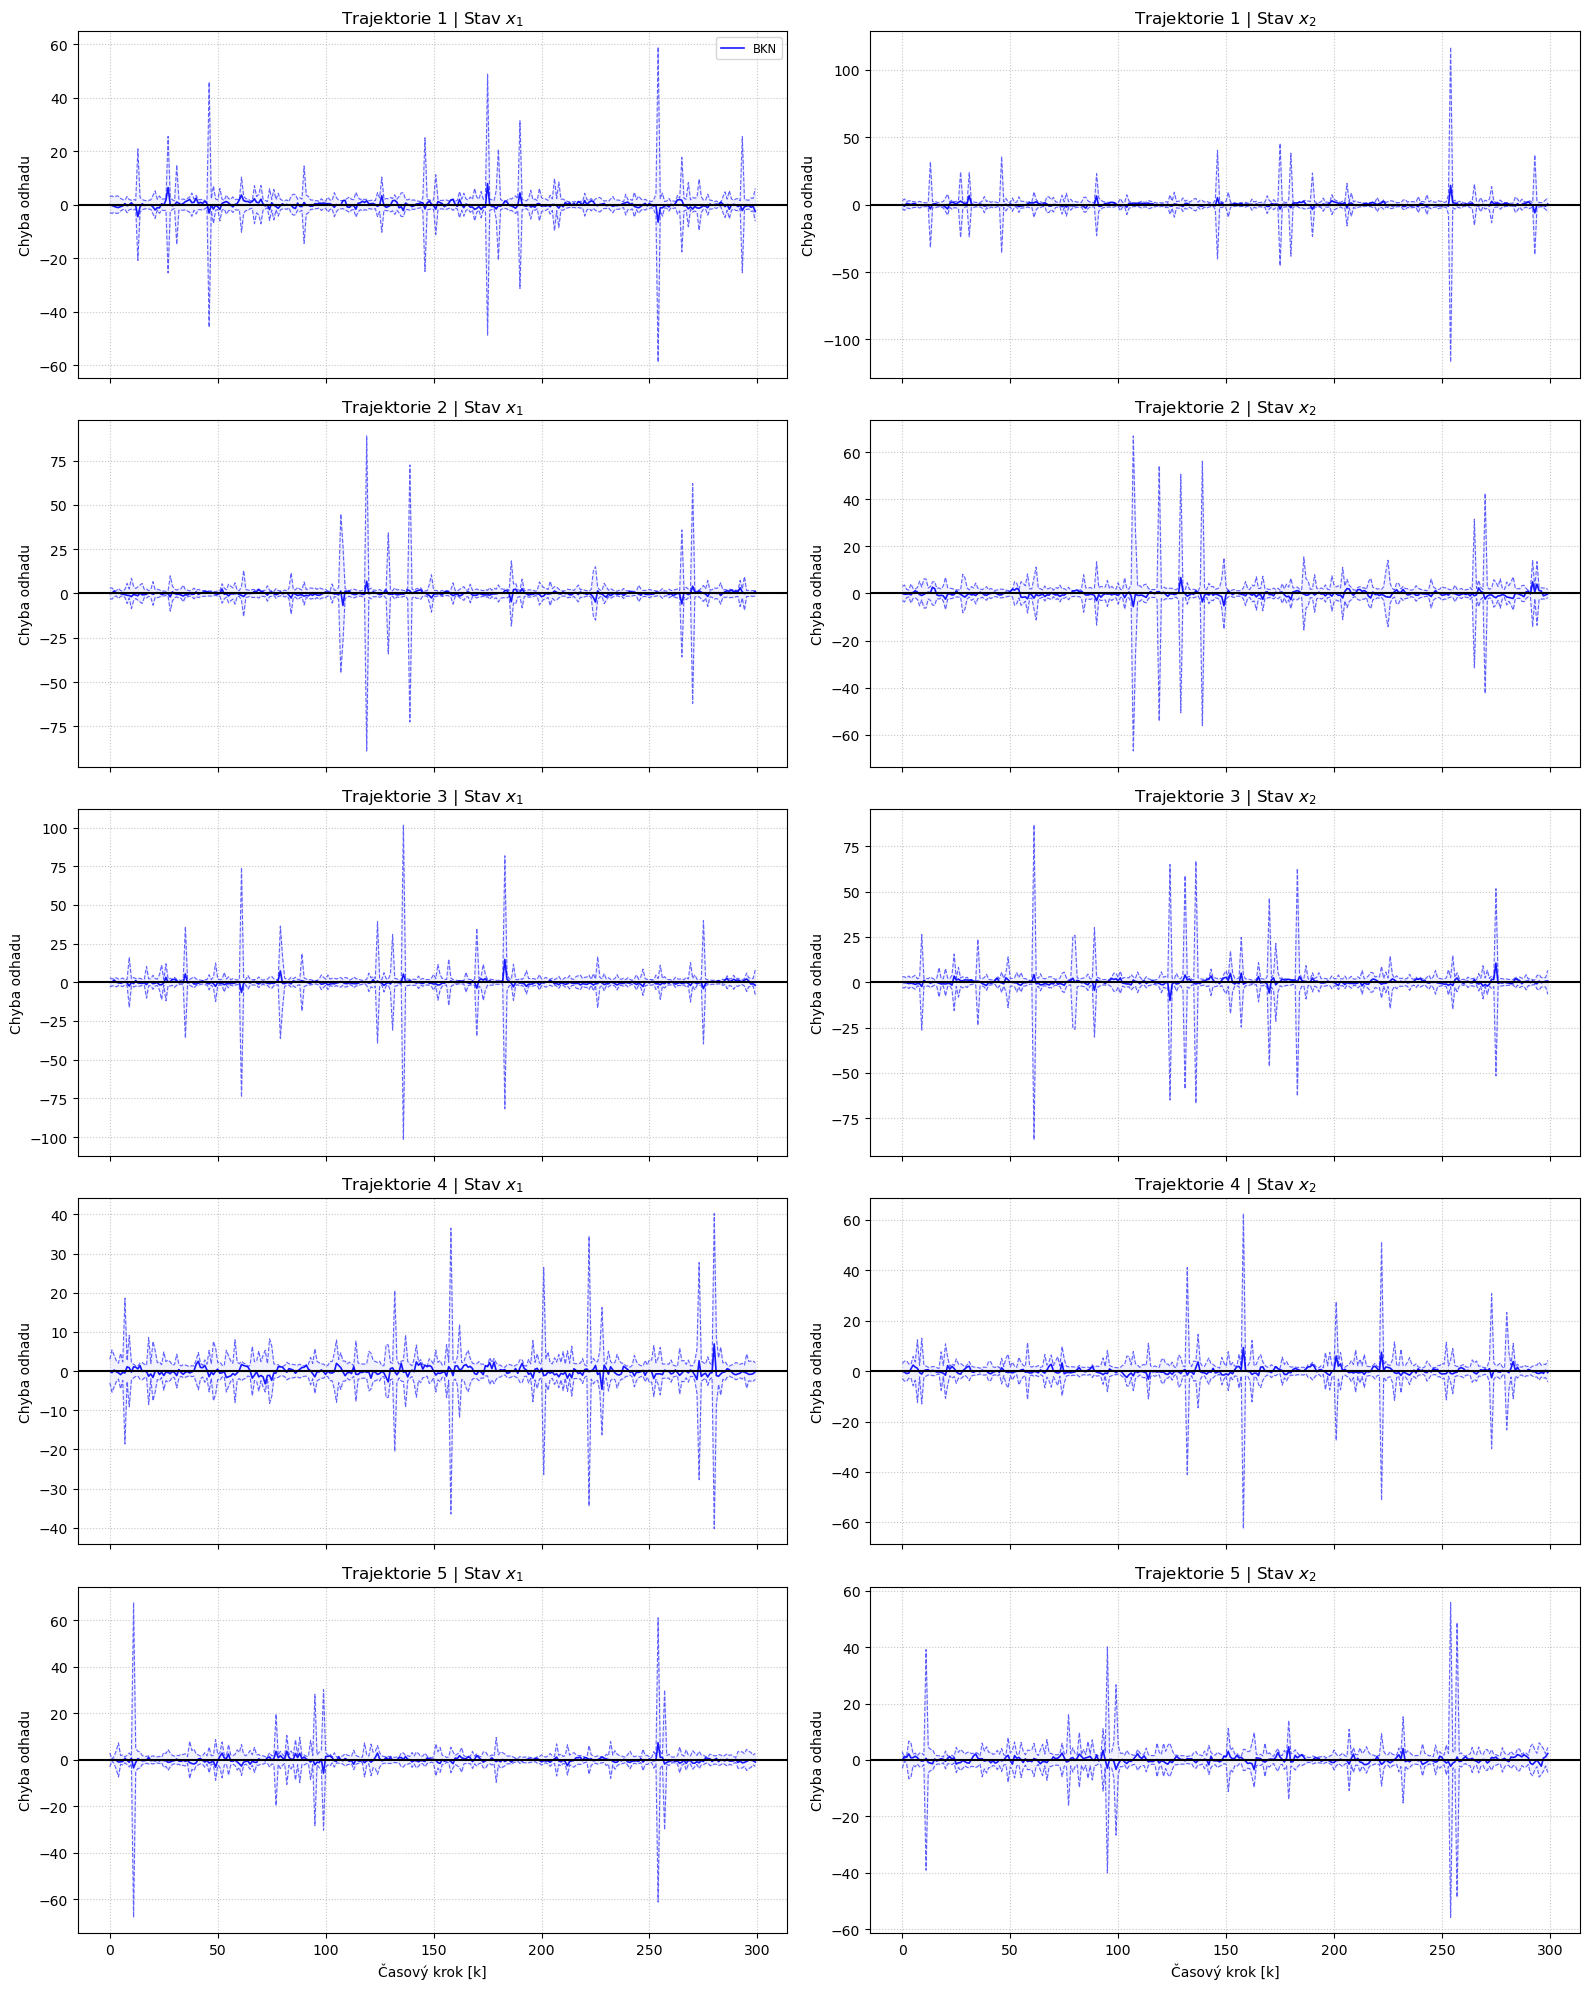

In [11]:
import matplotlib.pyplot as plt

# ==============================================================================
# 6. VYKRESLENÍ VÝVOJE CHYBY A 3-SIGMA OBÁLEK
# ==============================================================================
num_plot_traj = min(5, NUM_TEST_TRAJ)
state_dim = all_x_true_cpu[0].shape[1]
time_steps = np.arange(TEST_SEQ_LEN)

print(f"\nGeneruji grafy vývoje chyby a 3-sigma obálek pro prvních {num_plot_traj} trajektorií...")

# Barevná paleta pro jednotlivé modely
colors = {
    'BKN': 'blue',
    'KNetR': 'cyan',
    'EKF': 'red',
    'UKF': 'green',
    'PF': 'purple'
}

fig, axes = plt.subplots(num_plot_traj, state_dim, figsize=(16, 4 * num_plot_traj), sharex=True)

# Ošetření pro případ, že vykreslujeme jen 1 trajektorii
if num_plot_traj == 1:
    axes = np.expand_dims(axes, axis=0)

for i in range(num_plot_traj):
    x_true = all_x_true_cpu[i].numpy()
    
    # Slovník se všemi výsledky pro aktuální trajektorii
    models_data = {
        'BKN': (all_x_hat_bkn_cpu[i].numpy(), all_P_hat_bkn_cpu[i].numpy()),
        # 'KNetR': (all_x_hat_knetR_cpu[i].numpy(), all_P_hat_knetR_cpu[i].numpy()),
        # 'EKF': (all_x_hat_ekf_ideal_cpu[i].numpy(), all_P_hat_ekf_ideal_cpu[i].numpy()),
        # 'UKF': (all_x_hat_ukf_ideal_cpu[i].numpy(), all_P_hat_ukf_ideal_cpu[i].numpy()),
        # 'PF': (all_x_hat_pf_ideal_cpu[i].numpy(), all_P_hat_pf_ideal_cpu[i].numpy())
    }
    
    for d in range(state_dim):
        ax = axes[i, d]
        
        # Referenční nulová čára (Ideální stav bez chyby)
        ax.axhline(0, color='black', linestyle='-', linewidth=1.5, zorder=3)
        
        for model_name, (x_hat, P_hat) in models_data.items():
            # Výpočet chyby: e_t = x_hat - x_true
            error = x_hat[:, d] - x_true[:, d]
            
            # Výpočet směrodatné odchylky sigma z diagonály kovarianční matice P
            # Použito np.abs pro numerickou stabilitu (P_hat by mělo být pozitivně definitní)
            std_dev = np.sqrt(np.abs(P_hat[:, d, d]))
            
            color = colors[model_name]
            
            # Vykreslení chybové křivky
            ax.plot(time_steps, error, label=f'{model_name}', color=color, linewidth=1.2, alpha=0.9)
            
            # Vykreslení spojité 3-sigma obálky (centrováno kolem nuly)
            ax.fill_between(time_steps, -3 * std_dev, 3 * std_dev, color=color, alpha=0.05)
            ax.plot(time_steps, 3 * std_dev, color=color, linestyle='--', linewidth=0.8, alpha=0.6)
            ax.plot(time_steps, -3 * std_dev, color=color, linestyle='--', linewidth=0.8, alpha=0.6)
            
        ax.set_title(f"Trajektorie {i+1} | Stav $x_{d+1}$")
        ax.set_ylabel("Chyba odhadu")
        ax.grid(True, linestyle=':', alpha=0.7)
        
        # Omezení osy Y pro lepší čitelnost (odřízne obrovské ustřelení EKF)
        # ax.set_ylim([-5, 5]) # Tuto řádku můžeš odkomentovat, pokud bude EKF kazit měřítko grafu
        
        if i == 0 and d == 0:
            ax.legend(loc='upper right', ncol=2, fontsize='small')

# Nastavení osy X jen pro spodní řádek
for d in range(state_dim):
    axes[-1, d].set_xlabel("Časový krok [k]")

plt.tight_layout()
plt.show()